In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [38]:
# Load dataset
df = sns.load_dataset("tips")



In [39]:
# Inspect
print(df.head())


   total_bill   tip     sex smoker  day    time  size
0       16.99  1.01  Female     No  Sun  Dinner     2
1       10.34  1.66    Male     No  Sun  Dinner     3
2       21.01  3.50    Male     No  Sun  Dinner     3
3       23.68  3.31    Male     No  Sun  Dinner     2
4       24.59  3.61  Female     No  Sun  Dinner     4


In [40]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   total_bill  244 non-null    float64 
 1   tip         244 non-null    float64 
 2   sex         244 non-null    category
 3   smoker      244 non-null    category
 4   day         244 non-null    category
 5   time        244 non-null    category
 6   size        244 non-null    int64   
dtypes: category(4), float64(2), int64(1)
memory usage: 7.4 KB
None


In [21]:
#Simple feature engineering
# tip percentage (safe compute)
df['tip_pct'] = np.where(df['total_bill'] > 0, df['tip'] / df['total_bill'], 0.0)

In [22]:
# encode categorical variables as dummies
cat_cols = ['sex', 'smoker', 'day', 'time']
df_cat = pd.get_dummies(df[cat_cols].astype(str), drop_first=False)  # keep all dummies (interpretation later)
df_feats = pd.concat([df[['total_bill','tip','tip_pct','size']], df_cat], axis=1)

In [23]:
print("\nFeatures used (sample):")
display(df_feats.head())



Features used (sample):


,total_bill,tip,tip_pct,size,sex_Female,sex_Male,smoker_No,smoker_Yes,day_Fri,day_Sat,day_Sun,day_Thur,time_Dinner,time_Lunch
0,16.99,1.01,0.059447,2,True,False,True,False,False,False,True,False,True,False
1,10.34,1.66,0.160542,3,False,True,True,False,False,False,True,False,True,False
2,21.01,3.50,0.166587,3,False,True,True,False,False,False,True,False,True,False
3,23.68,3.31,0.139780,2,False,True,True,False,False,False,True,False,True,False
4,24.59,3.61,0.146808,4,True,False,True,False,False,False,True,False,True,False


In [25]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

#Scale features
scaler = StandardScaler()
X = df_feats.values.astype(float)
X_scaled = scaler.fit_transform(X)

In [26]:
# Keep feature names for interpretation later
feature_names = df_feats.columns.tolist()

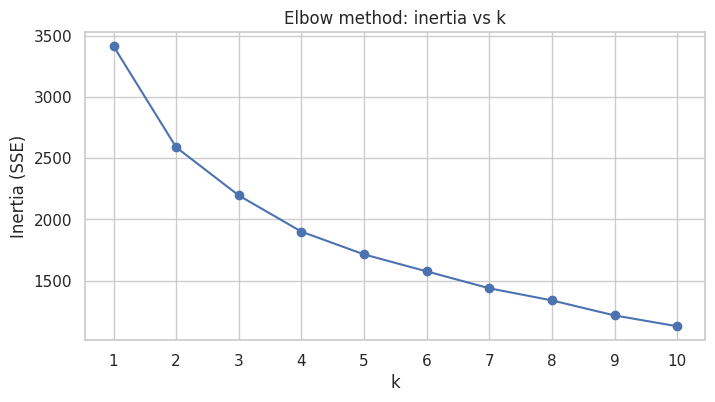

In [27]:
#Elbow method (inertia) and silhouette (k=2..10)
inertias = []
K = range(1, 11)
for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(8,4))
plt.plot(K, inertias, 'o-', markersize=6)
plt.xlabel('k')
plt.ylabel('Inertia (SSE)')
plt.title('Elbow method: inertia vs k')
plt.xticks(K)
plt.show()


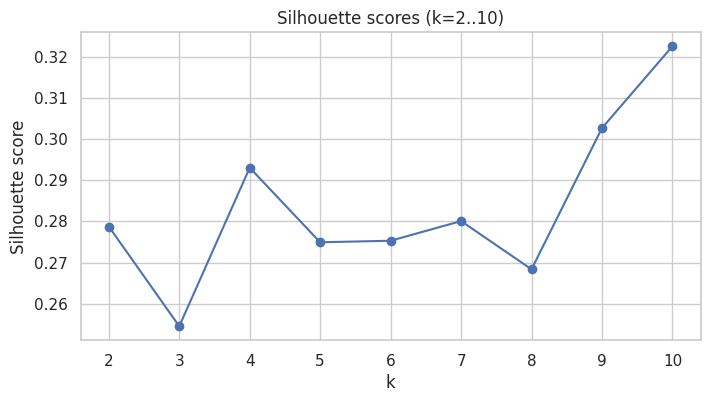

In [28]:
# silhouette scores for k=2..10
sil_scores = []
K_sil = range(2, 11)
for k in K_sil:
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = km.fit_predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(8,4))
plt.plot(list(K_sil), sil_scores, 'o-', markersize=6)
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette scores (k=2..10)')
plt.xticks(list(K_sil))
plt.show()

In [29]:
# choose best k by silhouette (automatic suggestion)
best_k = int(K_sil[np.argmax(sil_scores)])
print(f"Suggested k by silhouette = {best_k} (score = {max(sil_scores):.4f})")

Suggested k by silhouette = 10 (score = 0.3225)


In [30]:
#Fit KMeans with chosen k
k_opt = best_k
kmeans = KMeans(n_clusters=k_opt, random_state=42, n_init=50)
labels = kmeans.fit_predict(X_scaled)
df['cluster'] = labels

print("\nCluster sizes:")
print(df['cluster'].value_counts().sort_index())


Cluster sizes:
cluster
0    34
1    31
2    29
3    19
4    25
5    16
6    26
7    28
8    18
9    18
Name: count, dtype: int64


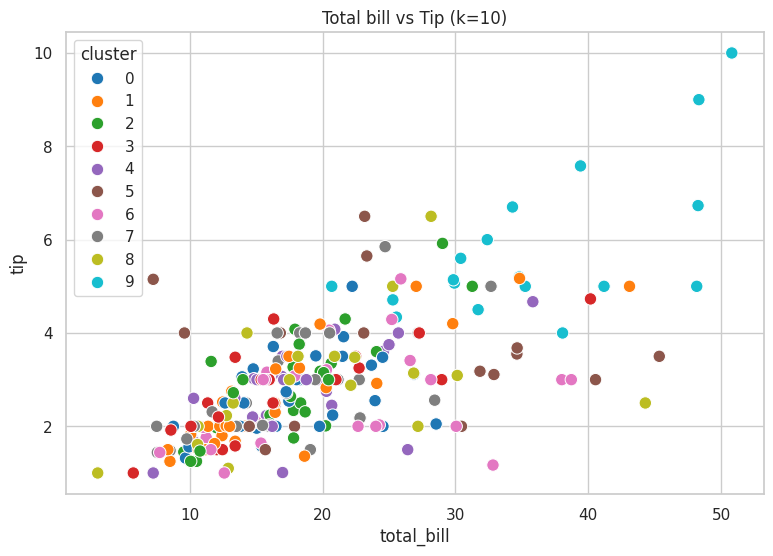

In [31]:
#Visualize clusters: total_bill vs tip (colored by cluster)
plt.figure(figsize=(9,6))
palette = sns.color_palette("tab10", n_colors=k_opt)
sns.scatterplot(data=df, x='total_bill', y='tip', hue='cluster', palette=palette, s=80)
plt.title(f"Total bill vs Tip (k={k_opt})")
plt.legend(title='cluster')
plt.show()


<Axes: >

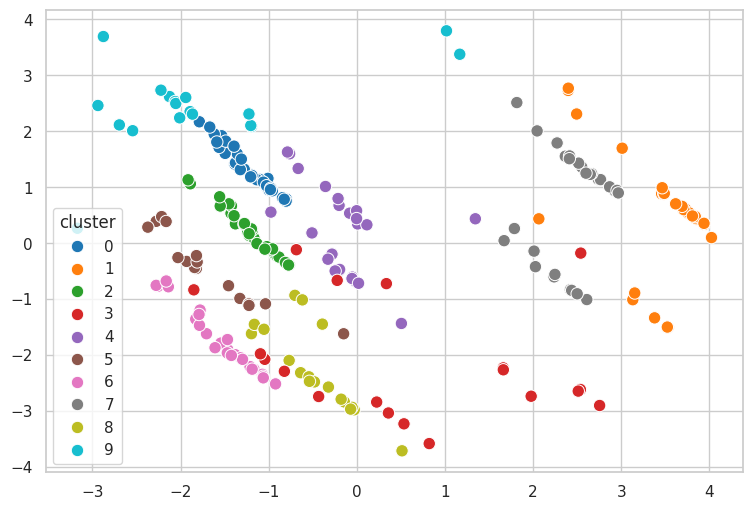

In [32]:
#PCA 2D visualization of clusters
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(9,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['cluster'], palette=palette, s=80)

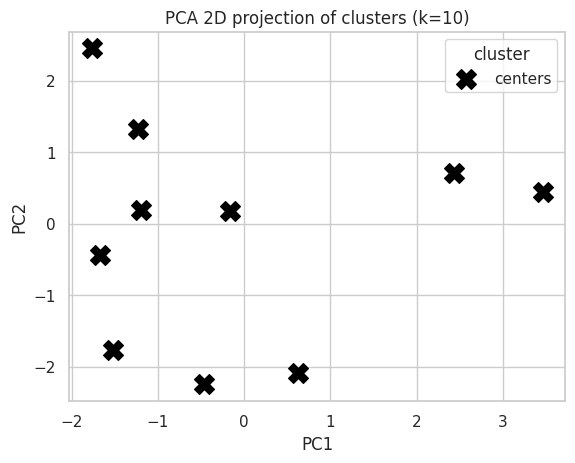

In [33]:
# overlay cluster centers (in PCA space)
centers_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers_pca[:,0], centers_pca[:,1], marker='X', s=200, c='black', label='centers')
plt.title(f"PCA 2D projection of clusters (k={k_opt})")
plt.legend(title='cluster')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.show()

In [34]:
#Interpret clusters: cluster centers in original feature units & profile table
centers_scaled = kmeans.cluster_centers_
centers_orig = scaler.inverse_transform(centers_scaled)
centers_df = pd.DataFrame(centers_orig, columns=feature_names)
centers_df['cluster'] = centers_df.index
print("\nCluster centers (approximate values in original feature space):")
display(centers_df.set_index('cluster').round(3))


Cluster centers (approximate values in original feature space):


,total_bill,tip,tip_pct,size,sex_Female,sex_Male,smoker_No,smoker_Yes,day_Fri,day_Sat,day_Sun,day_Thur,time_Dinner,time_Lunch
cluster,,,,,,,,,,,,,,
0,17.504,2.639,0.156,2.529,0.000,1.000,1.000,-0.000,-0.0,-0.000,1.000,-0.000,1.000,-0.000
1,16.649,2.562,0.157,2.484,1.000,-0.000,0.774,0.226,0.0,-0.000,0.000,1.000,0.000,1.000
2,17.300,2.790,0.161,2.517,0.000,1.000,1.000,-0.000,0.0,1.000,0.000,-0.000,1.000,0.000
3,17.152,2.735,0.170,2.105,0.474,0.526,0.211,0.789,1.0,0.000,-0.000,-0.000,0.632,0.368
4,18.298,2.788,0.158,2.480,1.000,0.000,1.000,-0.000,0.0,0.520,0.440,0.040,1.000,0.000
5,25.108,3.551,0.189,2.562,0.063,0.938,0.000,1.000,0.0,0.000,1.000,0.000,1.000,0.000
6,20.723,2.605,0.137,2.615,0.000,1.000,0.000,1.000,0.0,1.000,-0.000,-0.000,1.000,0.000
7,17.355,2.775,0.166,2.214,0.000,1.000,0.643,0.357,0.0,-0.000,0.000,1.000,0.000,1.000
8,20.031,2.946,0.166,2.278,1.000,0.000,0.000,1.000,0.0,0.833,0.167,-0.000,1.000,0.000


In [35]:
# Profile summary: mean values per cluster
profile = df.groupby('cluster')[['total_bill','tip','tip_pct','size']].mean().round(3)
profile['count'] = df.groupby('cluster').size()
print("\nCluster profile (means) for key numeric features:")
display(profile)


Cluster profile (means) for key numeric features:


,total_bill,tip,tip_pct,size,count
cluster,,,,,
0,17.504,2.639,0.156,2.529,34
1,16.649,2.562,0.157,2.484,31
2,17.300,2.790,0.161,2.517,29
3,17.152,2.735,0.170,2.105,19
4,18.298,2.788,0.158,2.480,25
5,25.108,3.551,0.189,2.562,16
6,20.723,2.605,0.137,2.615,26
7,17.355,2.775,0.166,2.214,28
8,20.031,2.946,0.166,2.278,18


In [36]:
# show example rows per cluster (first 3 each)
print("\nSample rows by cluster (up to 3 each):")
for c in sorted(df['cluster'].unique()):
    print(f"\n--- Cluster {c} (n={int(profile.loc[c,'count'])}) ---")
    display(df[df['cluster']==c].head(3)[['total_bill','tip','tip_pct','size','sex','smoker','day','time']])



Sample rows by cluster (up to 3 each):

--- Cluster 0 (n=34) ---


,total_bill,tip,tip_pct,size,sex,smoker,day,time
1,10.34,1.66,0.160542,3,Male,No,Sun,Dinner
2,21.01,3.50,0.166587,3,Male,No,Sun,Dinner
3,23.68,3.31,0.139780,2,Male,No,Sun,Dinner



--- Cluster 1 (n=31) ---


,total_bill,tip,tip_pct,size,sex,smoker,day,time
82,10.07,1.83,0.181728,1,Female,No,Thur,Lunch
85,34.83,5.17,0.148435,4,Female,No,Thur,Lunch
117,10.65,1.50,0.140845,2,Female,No,Thur,Lunch



--- Cluster 2 (n=29) ---


,total_bill,tip,tip_pct,size,sex,smoker,day,time
19,20.65,3.35,0.162228,3,Male,No,Sat,Dinner
20,17.92,4.08,0.227679,2,Male,No,Sat,Dinner
24,19.82,3.18,0.160444,2,Male,No,Sat,Dinner



--- Cluster 3 (n=19) ---


,total_bill,tip,tip_pct,size,sex,smoker,day,time
90,28.97,3.0,0.103555,2,Male,Yes,Fri,Dinner
91,22.49,3.5,0.155625,2,Male,No,Fri,Dinner
92,5.75,1.0,0.173913,2,Female,Yes,Fri,Dinner



--- Cluster 4 (n=25) ---


,total_bill,tip,tip_pct,size,sex,smoker,day,time
0,16.99,1.01,0.059447,2,Female,No,Sun,Dinner
4,24.59,3.61,0.146808,4,Female,No,Sun,Dinner
14,14.83,3.02,0.203641,2,Female,No,Sun,Dinner



--- Cluster 5 (n=16) ---


,total_bill,tip,tip_pct,size,sex,smoker,day,time
172,7.25,5.15,0.710345,2,Male,Yes,Sun,Dinner
173,31.85,3.18,0.099843,2,Male,Yes,Sun,Dinner
174,16.82,4.00,0.237812,2,Male,Yes,Sun,Dinner



--- Cluster 6 (n=26) ---


,total_bill,tip,tip_pct,size,sex,smoker,day,time
56,38.01,3.00,0.078927,4,Male,Yes,Sat,Dinner
58,11.24,1.76,0.156584,2,Male,Yes,Sat,Dinner
60,20.29,3.21,0.158206,2,Male,Yes,Sat,Dinner



--- Cluster 7 (n=28) ---


,total_bill,tip,tip_pct,size,sex,smoker,day,time
77,27.20,4.00,0.147059,4,Male,No,Thur,Lunch
78,22.76,3.00,0.131810,2,Male,No,Thur,Lunch
79,17.29,2.71,0.156738,2,Male,No,Thur,Lunch



--- Cluster 8 (n=18) ---


,total_bill,tip,tip_pct,size,sex,smoker,day,time
67,3.07,1.00,0.325733,1,Female,Yes,Sat,Dinner
72,26.86,3.14,0.116902,2,Female,Yes,Sat,Dinner
73,25.28,5.00,0.197785,2,Female,Yes,Sat,Dinner



--- Cluster 9 (n=18) ---


,total_bill,tip,tip_pct,size,sex,smoker,day,time
5,25.29,4.71,0.186240,4,Male,No,Sun,Dinner
11,35.26,5.00,0.141804,4,Female,No,Sun,Dinner
23,39.42,7.58,0.192288,4,Male,No,Sat,Dinner


In [37]:
# Save segmented dataset (optional)
out_path = "tips_kmeans_segments.csv"
df.to_csv(out_path, index=False)
print(f"\nSaved: {out_path}")
# If in Colab and you want to download:
# from google.colab import files
# files.download(out_path)


Saved: tips_kmeans_segments.csv
